In [1]:
from river.datasets import ImageSegments
from river.preprocessing import MinMaxScaler
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [
    ["brickface", "window", "cement"],
    ["sky", "foliage", "path", "grass"],
]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/cedrickulbach/Documents/Environments/deep-river3-10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


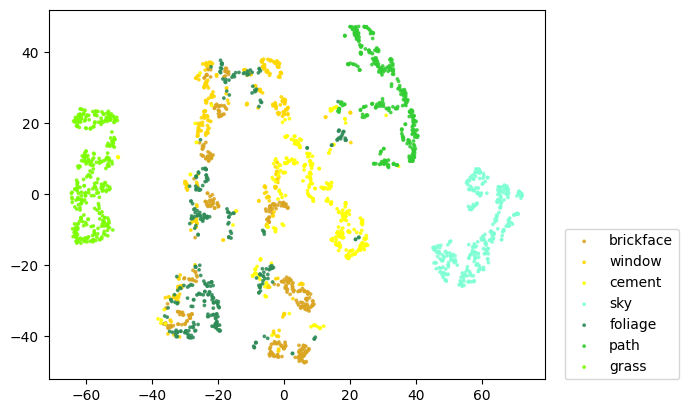

In [4]:
fig, ax = plt.subplots()
cm = [
    "goldenrod",
    "gold",
    "yellow",
    "aquamarine",
    "seagreen",
    "limegreen",
    "lawngreen",
]
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))

### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results

## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)


mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

  0%|                                                                                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                                                                          | 1/10000 [00:01<2:56:16,  1.06s/it]

  1%|██▋                                                                                                                                                                                                                                                                      | 100/10000 [00:01<01:29, 111.10it/s]

  2%|█████▎                                                                                                                                                                                                                                                                   | 200/10000 [00:01<00:44, 220.15it/s]

  3%|███████▉                                                                                                                                                                                                                                                                 | 300/10000 [00:01<00:30, 318.15it/s]

  4%|██████████▌                                                                                                                                                                                                                                                              | 400/10000 [00:01<00:23, 403.19it/s]

  5%|█████████████▎                                                                                                                                                                                                                                                           | 500/10000 [00:01<00:19, 482.30it/s]

  6%|███████████████▉                                                                                                                                                                                                                                                         | 600/10000 [00:01<00:17, 547.72it/s]

  7%|██████████████████▌                                                                                                                                                                                                                                                      | 700/10000 [00:02<00:15, 607.52it/s]

  8%|█████████████████████▏                                                                                                                                                                                                                                                   | 800/10000 [00:02<00:13, 658.60it/s]

  9%|███████████████████████▊                                                                                                                                                                                                                                                 | 900/10000 [00:02<00:13, 695.49it/s]

 10%|██████████████████████████▍                                                                                                                                                                                                                                             | 1000/10000 [00:02<00:12, 734.87it/s]

 11%|█████████████████████████████                                                                                                                                                                                                                                           | 1100/10000 [00:02<00:11, 761.63it/s]

 12%|███████████████████████████████▋                                                                                                                                                                                                                                        | 1200/10000 [00:02<00:11, 783.54it/s]

 13%|██████████████████████████████████▎                                                                                                                                                                                                                                     | 1300/10000 [00:02<00:10, 801.19it/s]

 14%|████████████████████████████████████▉                                                                                                                                                                                                                                   | 1400/10000 [00:02<00:10, 810.03it/s]

 15%|███████████████████████████████████████▌                                                                                                                                                                                                                                | 1500/10000 [00:03<00:10, 821.43it/s]

 16%|██████████████████████████████████████████▏                                                                                                                                                                                                                             | 1600/10000 [00:03<00:10, 837.19it/s]

 17%|████████████████████████████████████████████▉                                                                                                                                                                                                                           | 1700/10000 [00:03<00:09, 836.47it/s]

 18%|███████████████████████████████████████████████▌                                                                                                                                                                                                                        | 1800/10000 [00:03<00:09, 845.78it/s]

 19%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                     | 1900/10000 [00:03<00:09, 853.72it/s]

 20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                   | 2000/10000 [00:03<00:11, 700.28it/s]

 21%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 2080/10000 [00:03<00:10, 722.66it/s]

 22%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 2157/10000 [00:04<00:14, 538.84it/s]

 22%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 2220/10000 [00:04<00:14, 543.80it/s]

 23%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 2300/10000 [00:04<00:14, 547.79it/s]

 24%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 2400/10000 [00:04<00:12, 612.87it/s]

 25%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 2500/10000 [00:04<00:11, 675.04it/s]

 26%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 2600/10000 [00:04<00:10, 718.16it/s]

 27%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                | 2700/10000 [00:04<00:09, 760.19it/s]

 28%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 2800/10000 [00:04<00:09, 796.67it/s]

 29%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2900/10000 [00:05<00:09, 788.16it/s]

 30%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 3000/10000 [00:05<00:08, 801.99it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 3100/10000 [00:05<00:08, 811.95it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 3182/10000 [00:05<00:08, 812.06it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 3264/10000 [00:05<00:08, 771.98it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 3342/10000 [00:05<00:08, 746.29it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 3417/10000 [00:05<00:09, 726.92it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 3500/10000 [00:05<00:09, 718.03it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 3600/10000 [00:05<00:08, 716.57it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3700/10000 [00:06<00:08, 719.17it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 3800/10000 [00:06<00:08, 744.72it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 3900/10000 [00:06<00:07, 775.64it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 4000/10000 [00:06<00:07, 791.76it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 4100/10000 [00:06<00:07, 792.03it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 4200/10000 [00:06<00:07, 790.77it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 4300/10000 [00:06<00:07, 790.72it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 4400/10000 [00:06<00:07, 793.81it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 4500/10000 [00:07<00:06, 801.57it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 4600/10000 [00:07<00:06, 805.43it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 4700/10000 [00:07<00:06, 810.80it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 4800/10000 [00:07<00:06, 807.66it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4900/10000 [00:07<00:06, 798.39it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 5000/10000 [00:07<00:06, 789.07it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 5100/10000 [00:07<00:06, 793.43it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 5200/10000 [00:07<00:06, 787.19it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 5300/10000 [00:08<00:06, 770.42it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 5400/10000 [00:08<00:06, 759.38it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 5500/10000 [00:08<00:05, 761.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 5600/10000 [00:08<00:05, 745.65it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 5700/10000 [00:08<00:05, 753.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5800/10000 [00:08<00:05, 749.62it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 5900/10000 [00:08<00:05, 752.58it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 6000/10000 [00:09<00:05, 766.74it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 6100/10000 [00:09<00:05, 759.16it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 6200/10000 [00:09<00:05, 742.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 6300/10000 [00:09<00:05, 731.97it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 6400/10000 [00:09<00:04, 735.54it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6500/10000 [00:09<00:04, 738.08it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 6600/10000 [00:09<00:04, 732.21it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 6700/10000 [00:09<00:04, 733.78it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 6800/10000 [00:10<00:04, 737.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 6900/10000 [00:10<00:04, 725.10it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 7000/10000 [00:10<00:04, 730.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 7100/10000 [00:10<00:03, 728.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 7200/10000 [00:10<00:03, 724.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 7300/10000 [00:10<00:03, 730.93it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7400/10000 [00:10<00:03, 729.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 7500/10000 [00:11<00:03, 736.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 7600/10000 [00:11<00:03, 738.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7700/10000 [00:11<00:03, 733.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7800/10000 [00:11<00:03, 732.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7900/10000 [00:11<00:02, 740.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 8000/10000 [00:11<00:02, 743.39it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8100/10000 [00:11<00:02, 742.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8200/10000 [00:12<00:02, 743.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8300/10000 [00:12<00:02, 741.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8400/10000 [00:12<00:02, 739.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8500/10000 [00:12<00:02, 744.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8600/10000 [00:12<00:01, 750.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8700/10000 [00:12<00:01, 755.50it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8800/10000 [00:12<00:01, 755.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8900/10000 [00:12<00:01, 738.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9000/10000 [00:13<00:01, 737.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 9100/10000 [00:13<00:01, 739.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9200/10000 [00:13<00:01, 723.94it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9300/10000 [00:13<00:00, 719.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9400/10000 [00:13<00:00, 742.29it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9500/10000 [00:13<00:00, 761.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9600/10000 [00:13<00:00, 763.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9700/10000 [00:14<00:00, 728.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9800/10000 [00:14<00:00, 726.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9900/10000 [00:14<00:00, 725.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 745.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 692.03it/s]

In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

  0%|                                                                                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  1%|███▎                                                                                                                                                                                                                                                                    | 124/10000 [00:00<00:08, 1173.59it/s]

  2%|██████▍                                                                                                                                                                                                                                                                  | 242/10000 [00:00<00:14, 680.96it/s]

  3%|████████▌                                                                                                                                                                                                                                                                | 321/10000 [00:00<00:15, 618.68it/s]

  4%|██████████▌                                                                                                                                                                                                                                                              | 400/10000 [00:00<00:19, 487.82it/s]

  5%|█████████████▎                                                                                                                                                                                                                                                           | 500/10000 [00:00<00:15, 598.17it/s]

  6%|███████████████▉                                                                                                                                                                                                                                                         | 600/10000 [00:00<00:15, 621.29it/s]

  7%|███████████████████▌                                                                                                                                                                                                                                                     | 739/10000 [00:01<00:11, 803.53it/s]

  8%|██████████████████████                                                                                                                                                                                                                                                   | 831/10000 [00:01<00:14, 622.82it/s]

  9%|████████████████████████                                                                                                                                                                                                                                                 | 906/10000 [00:01<00:15, 602.45it/s]

 10%|██████████████████████████▍                                                                                                                                                                                                                                             | 1000/10000 [00:01<00:14, 638.93it/s]

 11%|█████████████████████████████                                                                                                                                                                                                                                           | 1100/10000 [00:01<00:12, 696.46it/s]

 12%|███████████████████████████████▋                                                                                                                                                                                                                                        | 1200/10000 [00:01<00:13, 633.26it/s]

 13%|██████████████████████████████████▎                                                                                                                                                                                                                                     | 1300/10000 [00:01<00:12, 705.11it/s]

 14%|████████████████████████████████████▉                                                                                                                                                                                                                                   | 1400/10000 [00:02<00:11, 770.74it/s]

 15%|████████████████████████████████████████                                                                                                                                                                                                                                | 1519/10000 [00:02<00:09, 876.05it/s]

 17%|████████████████████████████████████████████▉                                                                                                                                                                                                                           | 1700/10000 [00:02<00:08, 985.44it/s]

 18%|███████████████████████████████████████████████▌                                                                                                                                                                                                                        | 1802/10000 [00:02<00:09, 836.34it/s]

 19%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                     | 1900/10000 [00:02<00:12, 637.13it/s]

 20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                   | 2000/10000 [00:02<00:13, 615.01it/s]

 21%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 2100/10000 [00:03<00:12, 622.16it/s]

 22%|██████████████████████████████████████████████████████████                                                                                                                                                                                                              | 2200/10000 [00:03<00:12, 644.20it/s]

 23%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 2300/10000 [00:03<00:11, 682.12it/s]

 24%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 2400/10000 [00:03<00:10, 712.04it/s]

 25%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 2500/10000 [00:03<00:10, 729.36it/s]

 26%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 2600/10000 [00:03<00:10, 717.32it/s]

 27%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                | 2700/10000 [00:03<00:09, 740.84it/s]

 28%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 2800/10000 [00:04<00:09, 750.30it/s]

 29%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2900/10000 [00:04<00:09, 764.89it/s]

 30%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 3000/10000 [00:04<00:09, 735.47it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 3100/10000 [00:04<00:11, 618.96it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 3200/10000 [00:04<00:10, 628.91it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 3300/10000 [00:04<00:10, 633.82it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 3400/10000 [00:04<00:09, 666.30it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 3500/10000 [00:05<00:09, 712.59it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 3608/10000 [00:05<00:08, 798.27it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3700/10000 [00:05<00:07, 821.27it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 3800/10000 [00:05<00:07, 846.29it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 3900/10000 [00:05<00:07, 870.15it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 4000/10000 [00:05<00:06, 880.95it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 4115/10000 [00:05<00:06, 954.45it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 4214/10000 [00:05<00:06, 964.09it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 4312/10000 [00:05<00:06, 943.16it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 4408/10000 [00:06<00:05, 947.18it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 4508/10000 [00:06<00:05, 961.76it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 4635/10000 [00:06<00:05, 1051.31it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 4753/10000 [00:06<00:04, 1089.02it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4900/10000 [00:06<00:05, 981.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 5015/10000 [00:06<00:04, 1024.36it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 5121/10000 [00:06<00:05, 860.93it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 5214/10000 [00:06<00:06, 732.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 5300/10000 [00:07<00:07, 651.92it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 5400/10000 [00:07<00:07, 626.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 5500/10000 [00:07<00:07, 617.88it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 5600/10000 [00:07<00:07, 600.20it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 5700/10000 [00:07<00:07, 603.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5800/10000 [00:07<00:06, 623.31it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 5900/10000 [00:08<00:06, 635.97it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 6000/10000 [00:08<00:06, 615.39it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 6100/10000 [00:08<00:06, 565.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 6200/10000 [00:08<00:07, 475.36it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 6276/10000 [00:08<00:07, 523.26it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 6335/10000 [00:09<00:09, 372.08it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 6400/10000 [00:09<00:10, 340.60it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6500/10000 [00:09<00:09, 387.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 6600/10000 [00:09<00:07, 433.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 6700/10000 [00:10<00:07, 440.34it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 6800/10000 [00:10<00:06, 473.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 6900/10000 [00:10<00:06, 510.94it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 7000/10000 [00:10<00:05, 541.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 7100/10000 [00:10<00:05, 572.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 7200/10000 [00:10<00:04, 593.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 7300/10000 [00:10<00:04, 609.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7400/10000 [00:11<00:04, 605.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 7500/10000 [00:11<00:04, 596.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 7600/10000 [00:11<00:03, 612.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7700/10000 [00:11<00:03, 629.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7800/10000 [00:11<00:04, 482.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7900/10000 [00:12<00:04, 478.59it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 8000/10000 [00:12<00:04, 496.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8100/10000 [00:12<00:03, 488.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8200/10000 [00:12<00:03, 458.63it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8300/10000 [00:12<00:03, 483.98it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8400/10000 [00:13<00:03, 516.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8500/10000 [00:13<00:02, 530.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8600/10000 [00:13<00:02, 515.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8700/10000 [00:13<00:02, 549.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8800/10000 [00:13<00:02, 574.97it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8900/10000 [00:13<00:01, 602.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9000/10000 [00:14<00:01, 621.36it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 9100/10000 [00:14<00:01, 641.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9200/10000 [00:14<00:01, 652.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9300/10000 [00:14<00:01, 657.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9400/10000 [00:14<00:00, 639.18it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9500/10000 [00:14<00:00, 653.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9600/10000 [00:15<00:00, 657.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9700/10000 [00:15<00:00, 656.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9800/10000 [00:15<00:00, 590.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9900/10000 [00:15<00:00, 618.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 635.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 637.10it/s]

### Visualize Accuracy over Timesteps

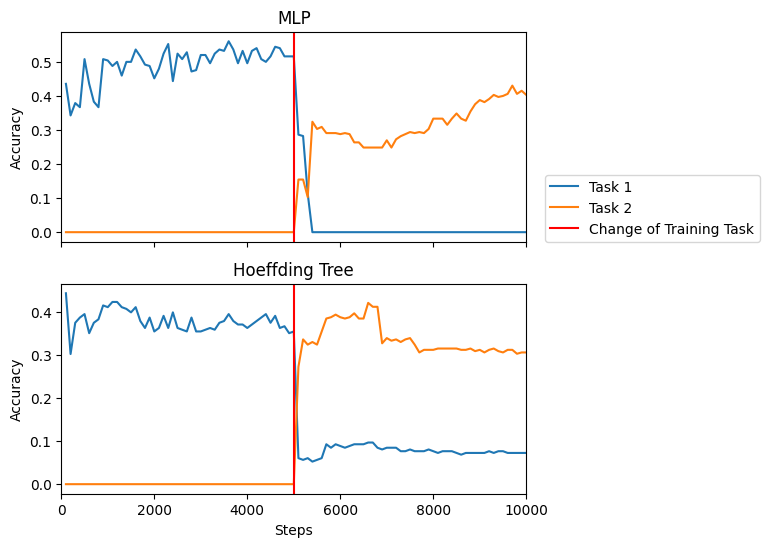

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))